# HRNet Pipeline

In this notebook, we show how to perform human pose estimation using a two-step approach. In particular, we use a Faster R-CNN for the person detection and a HRNet for the keypoint detection.

In [1]:
import os
import sys
from tqdm import tqdm

import numpy as np
import cv2
import torch
from torch.nn import DataParallel
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt

sys.path.append("..")

import models
import data
from data.data_loaders import get_vase_subset 
import data.data_processing as data_processing
from lib.transforms import TransformDetection
import lib.utils as utils
import lib.model_setup as model_setup
import lib.visualizations as visualizations
import lib.pose_parsing as pose_parsing
import lib.bounding_box as bbox_lib
from CONFIG import CONFIG
import CONSTANTS

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
exp_name = os.path.join("hrnet_tests", "styled_coco_augmented_epochs_150_lr_1e-3")
exp_path = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)
exp_detector = os.path.join(CONFIG["paths"]["experiments_path"], "detector_tests", "faster_rcnn_test")
data_path = CONFIG["paths"]["data_path"]
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_validation.json")
models_path = os.path.join(exp_path, "models")
detector_path = os.path.join(exp_detector, "models", "detector")
original_imgs_path = os.path.join(data_path, "original_images", "val2017")
styled_img_path = os.path.join(data_path, "images", "validation")

exp_data = utils.load_experiment_parameters(exp_path)
exp_data["dataset"]["dataset_name"] = "styled_coco"

In [4]:
pose_parsing.SKELETON = CONSTANTS.SKELETON_HRNET
data_processing.TO_COCO_MAP = CONSTANTS.COCO_MAP_HRNET
data_processing.SKIP_NECK = False

# 1. Dataset

In [5]:
# initializing a random data loader iterator to sample images from the 
# COCO validation set
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Normalize(
    mean=mean.tolist(), std=std.tolist()
)

In [6]:
hrnet_dataset = data.HRNetCoco(exp_data=exp_data, root=data_path, img_path=styled_img_path,
                               labels_path=labels_file, is_train=False, is_styled=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   normalize,
                               ]))

Loading /home/corrales/MasterThesis/data/mapping_dicts/valid_dict.json...
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [7]:
image_idx = np.random.randint(low=0, high=len(hrnet_dataset))
image_name = hrnet_dataset.get_name_given_id(image_idx)
print(f"ID: {image_idx}  --  Image: {image_name}")

ID: 1262  --  Image: 000000130699_stylized_pelike.jpg


In [8]:
image_name = "000000309655_stylized_dionysos.jpg"

In [9]:
# sampling a person-crop and the annotatios  
imgs, target, target_weight, metadata = hrnet_dataset.get_all_samples_given_name(image_name)
img_path = metadata["image"][0]
original_img_path = metadata["original_image"][0]
full_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)
original_img = cv2.imread(original_img_path, cv2.IMREAD_COLOR)
original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)

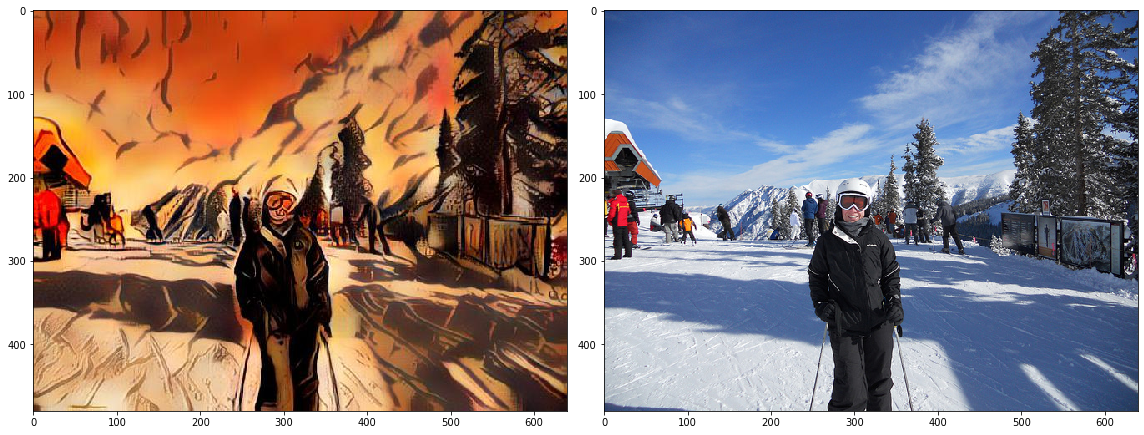

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,6)
visualizations.visualize_image(full_img, ax=ax[0])
visualizations.visualize_image(original_img, ax=ax[1])
plt.tight_layout()
plt.show()

# 2. Person Detection

In [13]:
process_img = original_img
# process_img = full_img

In [14]:
# detector with replaced RPN and classification head
# This model has been trained for 25 epochs on MS-COCO to detect persons
original_detector = fasterrcnn_resnet50_fpn(pretrained=True).eval()
detector = DataParallel(model_setup.setup_detector())
pretrained_path = os.path.join(detector_path, "checkpoint_epoch_25.pth")
checkpoint = torch.load(pretrained_path)
detector.load_state_dict(checkpoint['model_state_dict'])
detector = detector.eval()

In [15]:
# forward pass for predicting bboxes, labels and scores
img = torch.Tensor(process_img[np.newaxis, :].transpose(0,3,1,2))
original_outputs = original_detector(img / 255)
outputs = detector(img / 255)

In [16]:
original_boxes, original_labels, original_scores = bbox_lib.bbox_filtering(original_outputs, filter_=1, thr=0.7)
boxes, labels, scores = bbox_lib.bbox_filtering(outputs, filter_=1, thr=0.7)

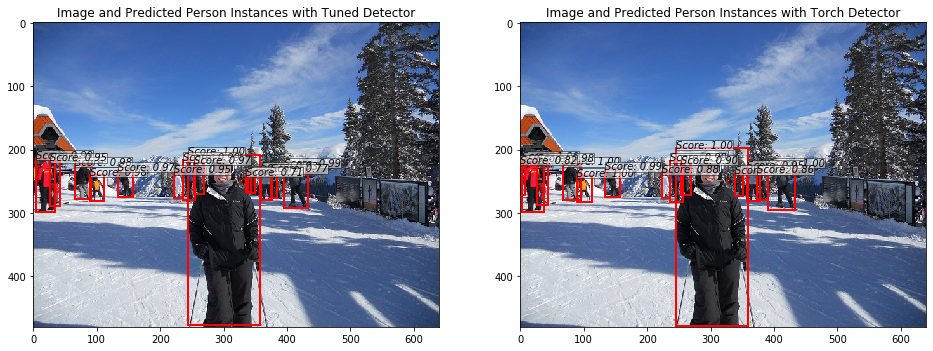

In [17]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,6)

title = "Image and Predicted Person Instances with Tuned Detector"
visualizations.visualize_bbox(img[0,:].cpu().numpy().transpose(1,2,0) / 255, 
                              boxes=boxes[0],  labels=labels[0],
                              scores=scores[0], ax=ax[0], title=title)

title = "Image and Predicted Person Instances with Torch Detector"
visualizations.visualize_bbox(img[0,:].cpu().numpy().transpose(1,2,0) / 255, 
                              boxes=original_boxes[0],  labels=original_labels[0],
                              scores=original_scores[0], ax=ax[1], title=title)

plt.show()

# 3. Cropping and Scaling

In [18]:
get_detections = TransformDetection(det_width=192, det_height=256)

In [19]:
img_extract = img[0,:].numpy().transpose(1,2,0)
detections, centers, scales = get_detections(img=img_extract, list_coords=boxes[0])

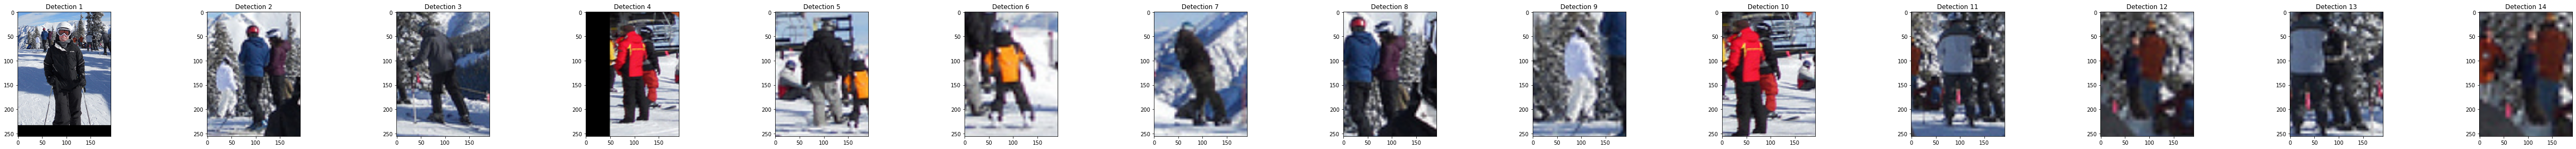

In [20]:
n_dets = detections.shape[0]
fig, ax = plt.subplots(1, n_dets)
if(n_dets == 1):
    ax = [ax]
fig.set_size_inches(5*n_dets, 4)
for i,det in enumerate(detections):
    title = f"Detection {i+1}"
    visualizations.visualize_image(det, ax=ax[i], preprocess=True, title=title)
plt.tight_layout()

# 4. Keypoint Detection

In [21]:
normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            )
normed_detections = [normalize(torch.Tensor(det/255)).numpy() for det in detections]

In [22]:
# HRNet Model instance
hrnet_model = model_setup.load_model(exp_data)
hrnet_model = DataParallel(hrnet_model)

# Tuned HRNet
tuned_hrnet = model_setup.load_model(exp_data)
tuned_hrnet = DataParallel(tuned_hrnet)
checkpoint_path = os.path.join(models_path, "checkpoint_epoch_100.pth")
tuned_hrnet = model_setup.load_checkpoint(checkpoint_path, tuned_hrnet, only_model=True)

In [23]:
# forward pass through HTNer for keypoint detection
original_keypoint_dets = hrnet_model(torch.Tensor(normed_detections).float())
original_scaled_dets = F.interpolate(original_keypoint_dets.clone().detach(), (256, 192),
                                     mode="bilinear", align_corners=True)

keypoint_dets = tuned_hrnet(torch.Tensor(normed_detections).float())
scaled_dets = F.interpolate(keypoint_dets.clone().detach(), (256, 192),
                            mode="bilinear", align_corners=True)


In [24]:
or_keypoint_coords, or_max_vals_coords = pose_parsing.get_max_preds_hrnet(original_scaled_dets.cpu().detach().numpy())
or_keypoints, or_max_vals, or_coords = pose_parsing.get_final_preds_hrnet(original_keypoint_dets.cpu().detach().numpy(), centers, scales)

keypoint_coords, max_vals_coords = pose_parsing.get_max_preds_hrnet(scaled_dets.cpu().detach().numpy())
keypoints, max_vals, coords = pose_parsing.get_final_preds_hrnet(keypoint_dets.cpu().detach().numpy(), centers, scales)

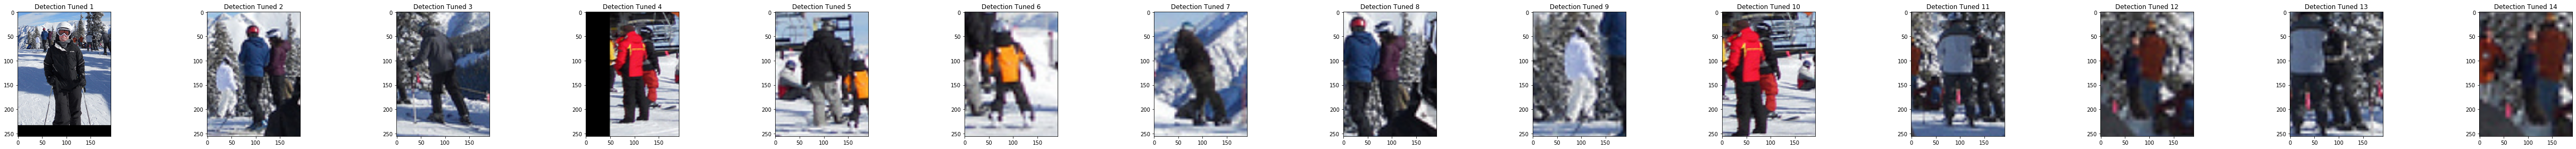

In [25]:
n_dets = detections.shape[0]
fig, ax = plt.subplots(1, n_dets)
if(n_dets == 1):
    ax = [ax]
fig.set_size_inches(5*n_dets, 4)
for i,det in enumerate(detections):
    title = f"Detection Tuned {i+1}"
    visualizations.visualize_image(det, ax=ax[i], preprocess=True, title=title)
plt.tight_layout()

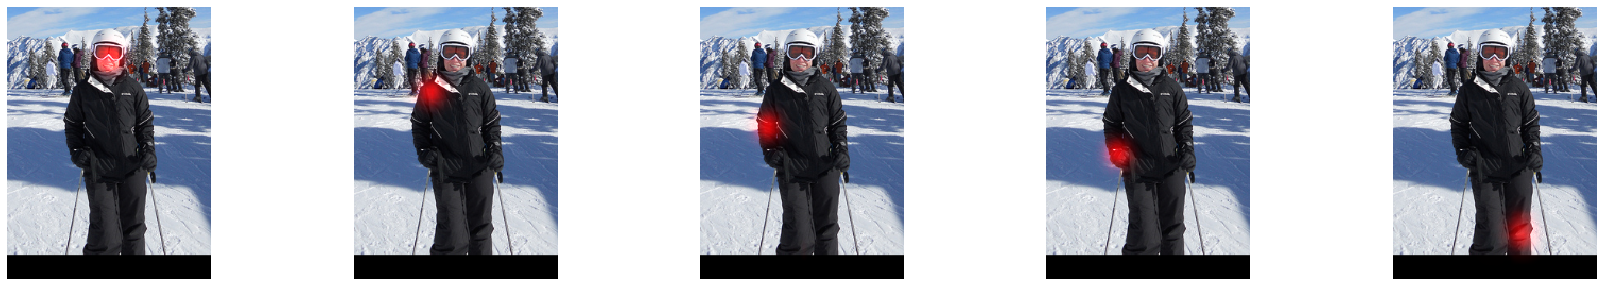

In [36]:
det_disp = detections[0]
cur_scaled_dets = scaled_dets[0,:]
idx = [0, 6, 8, 10, 13]

fig, ax = plt.subplots(1,5)
fig.set_size_inches(30,5)
for n,i in enumerate(idx):
    heatmap = cur_scaled_dets[i,:].cpu().numpy()
    visualizations.overlay_heatmap(heatmap, det_disp, ax= ax[n], axis_off=True)
plt.savefig(os.path.join(os.getcwd(),"imgs","heatmaps.png"))

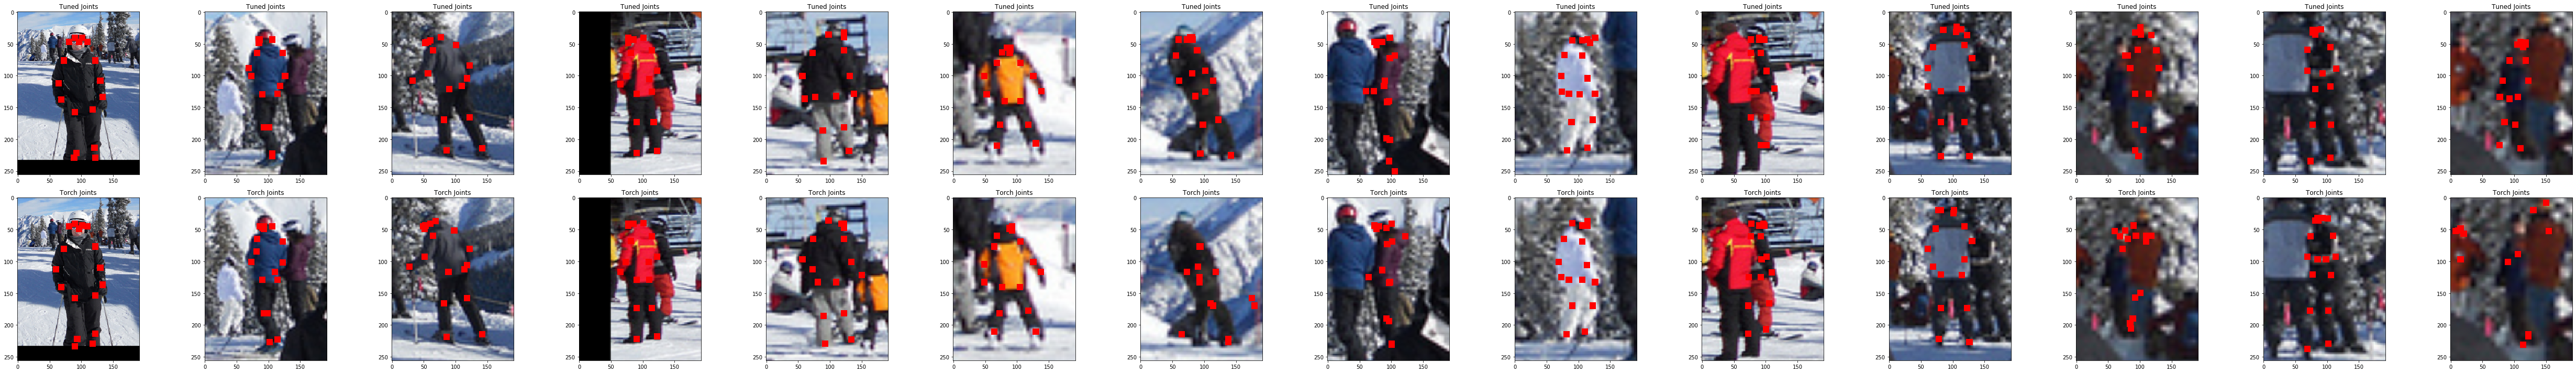

In [26]:
fig, ax = plt.subplots(2,n_dets)
fig.set_size_inches(5*n_dets, 10)
zoom = 5
if(n_dets == 1):
    ax = ax[:,np.newaxis]

for idx, det in enumerate(detections):
    aux = np.copy(det)
    for i, k in enumerate(keypoint_coords[idx]):
        k = [int(k_) for k_ in k]
        aux[0, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 255
        aux[1, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 0
        aux[2, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 0
    visualizations.visualize_image(aux, ax= ax[0, idx], preprocess=True, title=title)
    ax[0, idx].set_title("Tuned Joints")
    
    aux = np.copy(det)
    for i, k in enumerate(or_keypoint_coords[idx]):
        k = [int(k_) for k_ in k]
        aux[0, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 255
        aux[1, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 0
        aux[2, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 0
    visualizations.visualize_image(aux, ax= ax[1, idx], preprocess=True, title=title)
    ax[1, idx].set_title("Torch Joints")

plt.tight_layout()
plt.show()

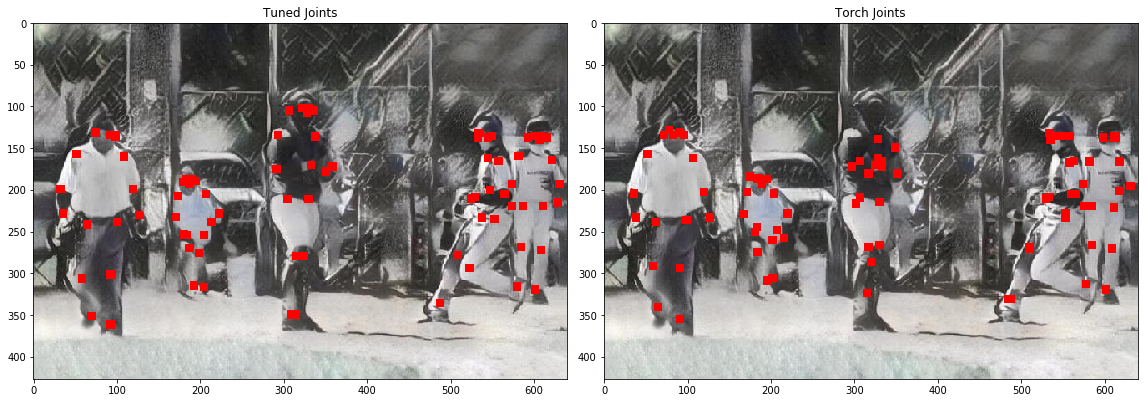

In [268]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 6)
zoom = 5

aux = np.copy(full_img).transpose(2,0,1)
for idx in range(keypoints.shape[0]): 
    for i, k in enumerate(keypoints[idx,:]):
        k = [int(k_) for k_ in k]
        aux[0, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 255
        aux[1, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 0
        aux[2, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 0
visualizations.visualize_image(aux, ax=ax[0], preprocess=True, title=title)
ax[0].set_title("Tuned Joints")

aux = np.copy(full_img).transpose(2,0,1)
for idx in range(or_keypoints.shape[0]): 
    for i, k in enumerate(or_keypoints[idx,:]):
        k = [int(k_) for k_ in k]
        aux[0, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 255
        aux[1, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 0
        aux[2, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 0
visualizations.visualize_image(aux, ax=ax[1], preprocess=True, title=title)
ax[1].set_title("Torch Joints")

plt.tight_layout()
plt.show()

# 5. Pose Parsing

In [269]:
or_indep_pose_entries, or_indep_all_keypoints = pose_parsing.create_pose_entries(or_keypoint_coords,  or_max_vals, thr=0.1)
or_pose_entries, or_all_keypoints = pose_parsing.create_pose_entries(or_keypoints, or_max_vals, thr=0.1)

or_indep_all_keypoints = [or_indep_all_keypoints[:, 1], or_indep_all_keypoints[:, 0],#
                          or_indep_all_keypoints[:, 2], or_indep_all_keypoints[:, 3]]
or_indep_all_keypoints = np.array(or_indep_all_keypoints).T

or_all_keypoints = [or_all_keypoints[:, 1], or_all_keypoints[:, 0],
                    or_all_keypoints[:, 2], or_all_keypoints[:, 3]]
or_all_keypoints = np.array(or_all_keypoints).T

In [270]:
indep_pose_entries, indep_all_keypoints = pose_parsing.create_pose_entries(keypoint_coords,  max_vals, thr=0.1)
pose_entries, all_keypoints = pose_parsing.create_pose_entries(keypoints, max_vals, thr=0.1)

indep_all_keypoints = [indep_all_keypoints[:, 1], indep_all_keypoints[:, 0], indep_all_keypoints[:, 2], indep_all_keypoints[:, 3]]
indep_all_keypoints = np.array(indep_all_keypoints).T

all_keypoints = [all_keypoints[:, 1], all_keypoints[:, 0], all_keypoints[:, 2], all_keypoints[:, 3]]
all_keypoints = np.array(all_keypoints).T

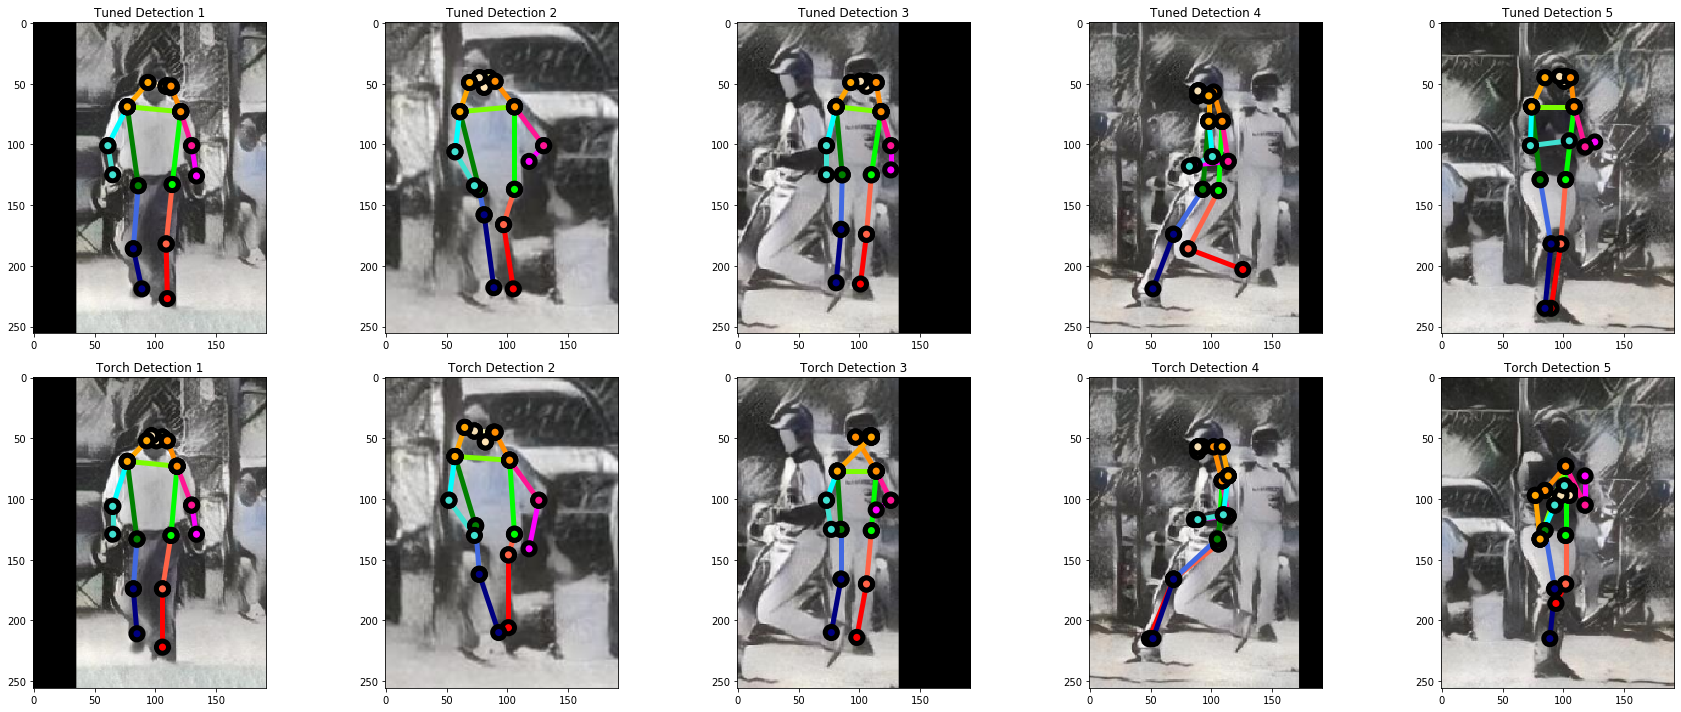

In [271]:
n_dets = detections.shape[0]
fig, ax = plt.subplots(2, n_dets)
if(n_dets == 1):
    ax = ax[:,np.newaxis]
fig.set_size_inches(5*n_dets, 10)
for i,det in enumerate(detections):
    title = f"Tuned Detection {i+1}"
    visualizations.draw_pose(det, [indep_pose_entries[i]], indep_all_keypoints,
                             ax=ax[0, i], title=title, preprocess=True)
    title = f"Torch Detection {i+1}"
    visualizations.draw_pose(det, [or_indep_pose_entries[i]], or_indep_all_keypoints,
                             ax=ax[1, i], title=title, preprocess=True)
plt.tight_layout()

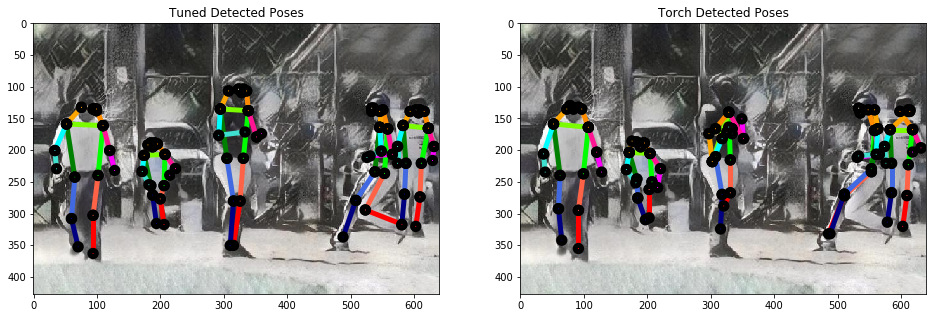

In [272]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,6)

title = f"Tuned Detected Poses"
visualizations.draw_pose(img[0,:].cpu().numpy().transpose(1,2,0) / 255,
                         pose_entries, all_keypoints, ax=ax[0], title=title)

title = f"Torch Detected Poses"
visualizations.draw_pose(img[0,:].cpu().numpy().transpose(1,2,0) / 255,
                         or_pose_entries, or_all_keypoints, ax=ax[1], title=title)

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 